This notebook implements 2D simulations of the microscopic model.

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.stats import expon
from numpy import random, linalg

In [ ]:
#centers of traps
realtrap = np.array([(-141.42, 141.42), (-138.08, 57.4), (-184.78, -76.54), (50, 0),
                     (57.4,138.58),(-38.27, 92.39), (19.13, -46.19), (0,-100),
                     (76.54, -184.78), (-393.92, -99.46),(-153.07,-369.55),
                     (-95.67, -230.97), (-57.4, -138.58), (400,0), (282.84,-282.84),
                     (212.13,-212.13), (168.68, 107.46), (100, 0), (-35.36, 35.36),
                     (-282.84, 282.84), (-95.67, 230.97)])
#number of traps
P = len(realtrap)

numberOfTrappedIndivs=np.zeros(P)


In [ ]:
#number of mousquito
N=10000

#inverse of life expectancy and life time
nu=1.0/10
lifetime = np.random.exponential(1/nu, size = N)
AliveIndiv=np.ones(N)


#time of simulation (in days)
Tend=20
#time step size
dt=0.1
#traps radius size, effect until 10*r
r=10


Movement: At the start of the release experiment, there are $N_0=10^4$ mosquitoes, all of which are released at the same point $x_0 \in \mathbb{R}^2$. We assume that their positions at time $t$ are governed by independent 2-dimensional Itô diffusion processes:
\begin{equation}
    dX_t = \sigma dB_t, \quad X_0 = x_0,
\end{equation}
where $dB_t$ denotes an increment in time of a standard 2-dimensional Brownian motion, and $\sigma$ describes the homogen mosquito mobility, which may vary depending on local conditions.

In [ ]:
#mobility coefficient
sigma=80
#mosqitos position
CoordIndiv= np.zeros((N, 2))
#Brownian motion for the homogeneous case
def brownian_motion():
    global CoordIndiv
    CoordIndiv+=norm.rvs(size=CoordIndiv.shape,scale=sigma*np.sqrt(dt))


Trapping: The traps, indexed by $i=1,\ldots,21$, are located at positions $q_i \in \mathbb{R}^2$. For a mosquito at position $X_t$, the probability of being trapped in trap $i$ follows an exponential distribution with the parameter $f_i(X_t) = \gamma \, \exp\left(-\|X_t - q_i\|^2 / R^2\right)$. The constant $R > 0$ (assumed to be $R = 10$~m) represents the characteristic distance over which the trap's effectiveness diminishes with increasing distance from $q_i$.

In [ ]:
#trapping rate
gamma=2.0/3.0

def capture():
    distances = np.linalg.norm(CoordIndiv[:, np.newaxis, :] - realtrap[np.newaxis, :, :], axis=2)
    #distance[0] contains distance betweens indiv 0 to all traps
    #distance[i,j] i: index of indiv, j: index of trap
    index_closest_traps = np.argmin(distances, axis=1)
    # Compute distances to the nearest traps
    distances_closest = distances[np.arange(N), index_closest_traps]
    # Condition : distance < 10 * r
    mask = distances_closest < 10 * r
    # Compute  fgamma for the indiv concerned
    fgamma = np.zeros(N)
    fgamma[mask] = gamma * np.exp(-(distances_closest[mask] / r) ** 2)
    # trap proba
    capture_probs = np.zeros(N)
    capture_probs[mask] = 1 - np.exp(-fgamma[mask] * dt)
    # Generate random proba
    random_probs = np.random.uniform(0, 1, size=N)
    # Capture condition
    capture_mask = (random_probs < capture_probs) & (curT < lifetime) & (AliveIndiv == 1)
    # Update captured individuals
    AliveIndiv[capture_mask] = 0
    # Count captures per trap
    np.add.at(numberOfTrappedIndivs, index_closest_traps[capture_mask], 1)

countCaptured=np.zeros((P,Tend))


The simulator:

In [ ]:
def doTimeStep():
    brownian_motion()
    capture()

def doSimu():
    global curT, countCaptured,raster, lifetime
    lifetime = np.random.exponential(1/nu, size = N)
    curT=0.0
    for day in range(Tend):
        print(day)
        numberOfTrappedIndivs.fill(0)
        while (curT < day+1):
            doTimeStep()
            curT+=dt
        countCaptured[:,day]=numberOfTrappedIndivs
doSimu()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


see the trapped

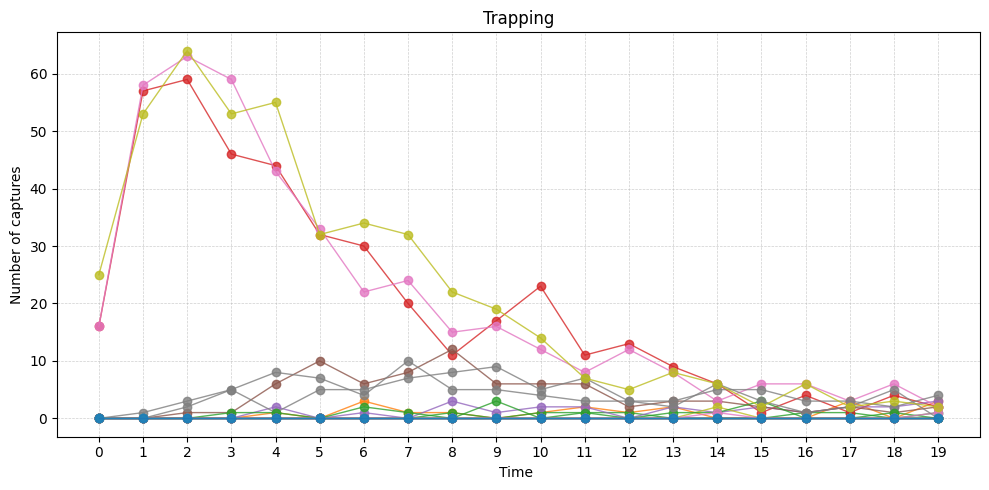

In [ ]:
import matplotlib.pyplot as plt

t = np.arange(Tend)  #

fig, ax = plt.subplots(figsize=(10,5))
for i in range(P):
    ax.plot(t, countCaptured[i], marker='o', linewidth=1, alpha=0.8)

ax.set_title("Trapping")
ax.set_xlabel("Time ")
ax.set_ylabel("Number of captures")
ax.set_xticks(t)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

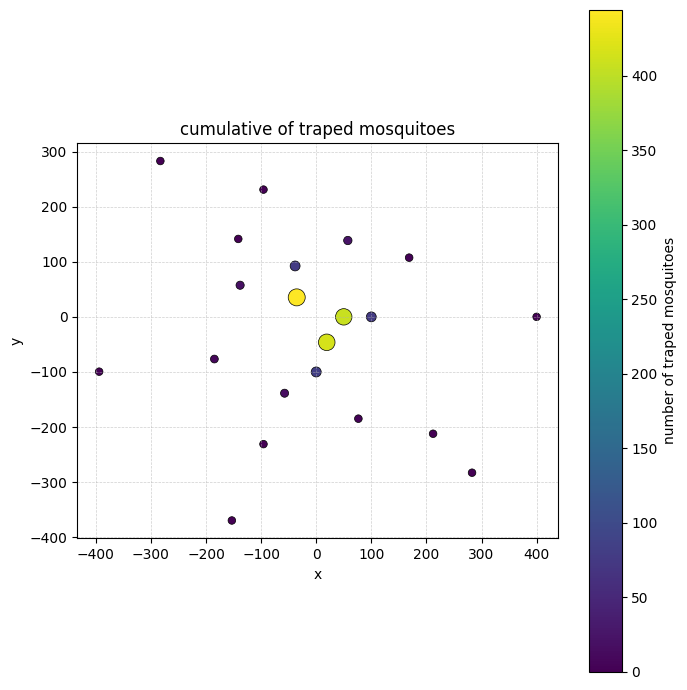

In [ ]:
import matplotlib.pyplot as plt



# 1)  cumule trapping
qty = countCaptured.sum(axis=1)


# --- get traps coordonates ---
xy = np.asarray(realtrap)
x, y = xy[:, 0], xy[:, 1]

# --- size inside graphic ---
if qty.max() > 0:
    sizes = 30 + 120 * (qty / qty.max())
else:
    sizes = 50 * np.ones_like(qty)

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 7))
sc = ax.scatter(x, y, c=qty, s=sizes, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("number of traped mosquitoes")

ax.set_title("cumulative of traped mosquitoes")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

#  aligne
pad = 0.05
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
dx, dy = xmax - xmin, ymax - ymin
ax.set_xlim(xmin - pad*dx, xmax + pad*dx)
ax.set_ylim(ymin - pad*dy, ymax + pad*dy)

plt.tight_layout()
plt.show()

Heterogen diffusion

In [ ]:
import numpy as np
from matplotlib.patches import Polygon
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from shapely.geometry import Point
import math

# Herogen landscapes description
landscapes = {
    "poly1": np.array([[-250, -69], [-137, -212], [-142, -212], [-170, -384], [-116, -507], [43, -509],
                  [42, -336], [119, -334], [243, -213], [151, -110], [145, 151], [183, 169], [160, 227], [-163, 178]]),
    "poly2": np.array([[-453, -105], [-337, -80], [-301, -140], [-308, -192], [-388, -295], [-417, -156], [-457, -147]]),
    "poly3": np.array([[463, 11], [392, 24], [376, 143], [246, 136], [251, 7], [427, -64], [481, -65]]),
    "poly4": np.array([[381, 510], [355, 389], [511, 275], [514, 516]]),
    "poly5": np.array([[-510, 90], [-427.5, 34.5], [-309, 9], [-351, 239], [-155, 516], [-510, 516]])
}


def is_inside_polygon(point, polygon):
    return polygon.contains_point(point)

from scipy.spatial.distance import euclidean
# compute the point to edge length
def point_to_segment_distance(point, segment_start, segment_end):
    px, py = point
    sx, sy = segment_start
    ex, ey = segment_end
    # edge
    segment_vector = np.array([ex - sx, ey - sy])
    # point
    point_vector = np.array([px - sx, py - sy])
    # Proj point on edge
    segment_length_squared = np.dot(segment_vector, segment_vector)
    if segment_length_squared == 0:
        # proj on the edge
        return euclidean(point, segment_start)
    t = max(0, min(1, np.dot(point_vector, segment_vector) / segment_length_squared))
    # Point
    projection = np.array([sx, sy]) + t * segment_vector
    # point to proj length
    return euclidean(point, projection)

# compute the distance point to landscape
# return a smooth weight equals 1 inside, 0 outside.
distSmooth=15
def point_to_polygons_weight(point, polygons):
    min_distance = float('inf')
    isInside=False
    for vertices in polygons.values():
        polygon = Polygon(vertices)
        isInside =isInside or  is_inside_polygon(point, polygon)
        # get minimal distance point to polygon
        num_vertices = len(vertices)
        for i in range(num_vertices):
            segment_start = vertices[i]
            segment_end = vertices[(i + 1) % num_vertices]
            distance = point_to_segment_distance(point, segment_start, segment_end)
            min_distance = min(min_distance, distance)
    if (isInside):
        if (min_distance<distSmooth):
            return 1-0.5*(math.exp(-2*(min_distance/distSmooth)*(min_distance/distSmooth)))
        else:
            return 1
    else:
        if (min_distance>distSmooth):
            return 0.0
        else:
            return 0.5*math.exp(-2*((distSmooth+min_distance)/distSmooth)*((distSmooth+min_distance)/distSmooth))

In [ ]:
sigma1=20
sigma2=60
def heterogen_brownian_motion():
    global CoordIndiv
    for c in CoordIndiv:
        weight=point_to_polygons_weight(c,landscapes)
        sigmah=weight*sigma1+(1-weight)*sigma2
        c+=norm.rvs(size=2,scale=sigmah*np.sqrt(dt))

In [ ]:
dt=0.5
def doTimeStepHeterogen():
    heterogen_brownian_motion()
    capture()

def doSimu():
    global curT, countCaptured,raster, lifetime
    lifetime = np.random.exponential(1/nu, size = N)
    curT=0.0
    for day in range(Tend):
        print(day)
        numberOfTrappedIndivs.fill(0)
        while (curT < day+1):
            doTimeStepHeterogen()
            curT+=dt
        countCaptured[:,day]=numberOfTrappedIndivs
doSimu()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


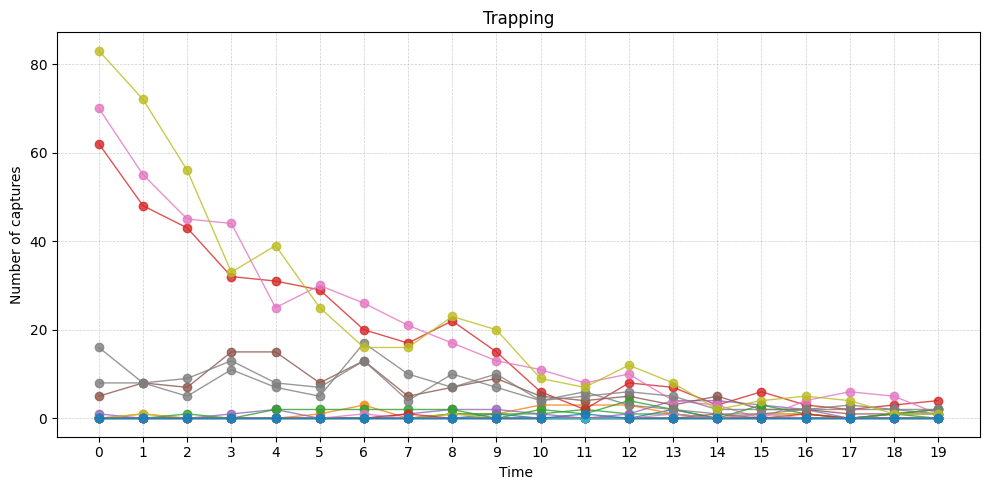

In [ ]:
import matplotlib.pyplot as plt

t = np.arange(Tend)  #

fig, ax = plt.subplots(figsize=(10,5))
for i in range(P):
    ax.plot(t, countCaptured[i], marker='o', linewidth=1, alpha=0.8)

ax.set_title("Trapping")
ax.set_xlabel("Time ")
ax.set_ylabel("Number of captures")
ax.set_xticks(t)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

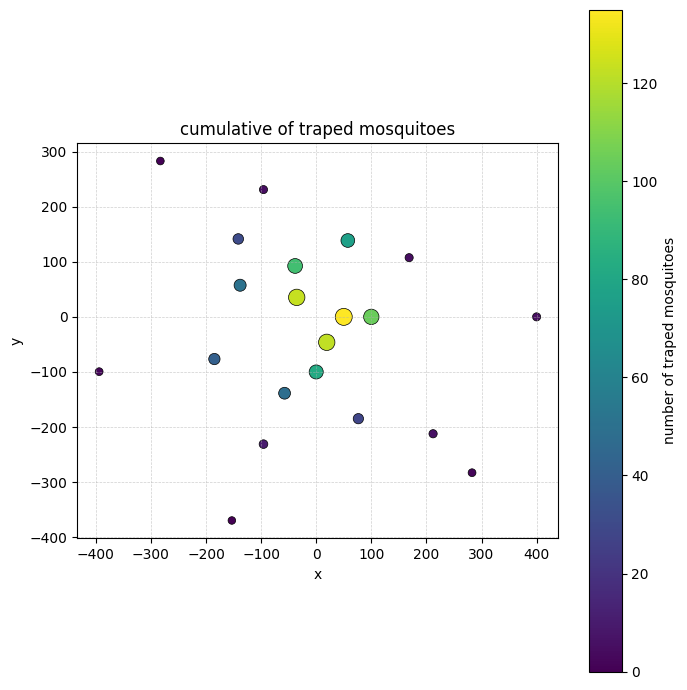

In [ ]:
import matplotlib.pyplot as plt


# 1)  cumule trapping
qty = countCaptured.sum(axis=1)


# --- get traps coordonates ---
xy = np.asarray(realtrap)
x, y = xy[:, 0], xy[:, 1]

# --- size inside graphic ---
if qty.max() > 0:
    sizes = 30 + 120 * (qty / qty.max())
else:
    sizes = 50 * np.ones_like(qty)

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 7))
sc = ax.scatter(x, y, c=qty, s=sizes, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("number of traped mosquitoes")

ax.set_title("cumulative of traped mosquitoes")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

#  aligne
pad = 0.05
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
dx, dy = xmax - xmin, ymax - ymin
ax.set_xlim(xmin - pad*dx, xmax + pad*dx)
ax.set_ylim(ymin - pad*dy, ymax + pad*dy)

plt.tight_layout()
plt.show()